In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12.0, 7.0]
from IPython.display import set_matplotlib_formats, clear_output
set_matplotlib_formats('retina')

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso, SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer
from sklearn.preprocessing import FunctionTransformer

from load_utils import load_data
from features import mean_of_var, wind_speed, wind_direction, all_features, k_diff
from CAPE_CNR_metric import CAPE_CNR_function
from models.sk_model import *
from models.lstm_models import *

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader



In [12]:
df, target = load_data()

In [13]:
features = all_features(df, get_diff=[1, 2, 3], test_set=True)

full_df = pd.concat([features, target], axis=1)

full_df_wfs = list(map(lambda df: df.drop('Production', axis=1), split_data_wf(full_df)))

In [14]:
prod_df_wfs = list(map(lambda features_df: features_df['Production'], split_data_wf(full_df)))
prod_wfs = list(map(lambda df: df.to_numpy(), prod_df_wfs))

### Sk model

In [15]:
model = SGDRegressor
parameters = dict(loss='huber', penalty='l2', alpha=0.0001,
                  fit_intercept=True, max_iter=200, tol=0.001,)
parameters = {f"model__{k}": [v] for k, v in parameters.items()}

# model = MLPRegressor
# parameters = {'model__alpha': 10.0 ** np.arange(-5, -4),
#                'model__hidden_layer_sizes': [(100,) * i for i in range(1, 2)]}

sk_regressor_full = SkRegressorFull(model, parameters)
sk_regressor_full.fit(full_df)

[I 200323 18:35:55 sk_model:160] Fit on WF 1
[I 200323 18:35:55 sk_model:224] score on test = 48.80
[D 200323 18:35:55 sk_model:225] {'model__alpha': 0.0001, 'model__fit_intercept': True, 'model__loss': 'huber', 'model__max_iter': 200, 'model__penalty': 'l2', 'model__tol': 0.001}
[I 200323 18:35:55 sk_model:160] Fit on WF 2
[I 200323 18:35:55 sk_model:224] score on test = 35.12
[D 200323 18:35:55 sk_model:225] {'model__alpha': 0.0001, 'model__fit_intercept': True, 'model__loss': 'huber', 'model__max_iter': 200, 'model__penalty': 'l2', 'model__tol': 0.001}
[I 200323 18:35:55 sk_model:160] Fit on WF 3
[I 200323 18:35:55 sk_model:224] score on test = 34.70
[D 200323 18:35:55 sk_model:225] {'model__alpha': 0.0001, 'model__fit_intercept': True, 'model__loss': 'huber', 'model__max_iter': 200, 'model__penalty': 'l2', 'model__tol': 0.001}
[I 200323 18:35:55 sk_model:160] Fit on WF 4
[I 200323 18:35:55 sk_model:224] score on test = 33.67
[D 200323 18:35:55 sk_model:225] {'model__alpha': 0.0001,

In [16]:
sk_predictions = sk_regressor_full.predict(full_df_wfs)

### LSTM

In [17]:
features = all_features(df, get_diff=[], test_set=True)

full_df = pd.concat([features, target], axis=1)

In [18]:
lstm_regressor = LstmRegressor({}, shift=12, id="mean_12")

In [19]:
lstm_predictions = lstm_regressor.predict(full_df)

In [20]:
df_test = load_data('data/X_test_v2.csv', path_Y=None)

features_test = all_features(df_test, get_diff=[], test_set=True)

predictions = lstm_regressor.predict(features_test)

### Compare

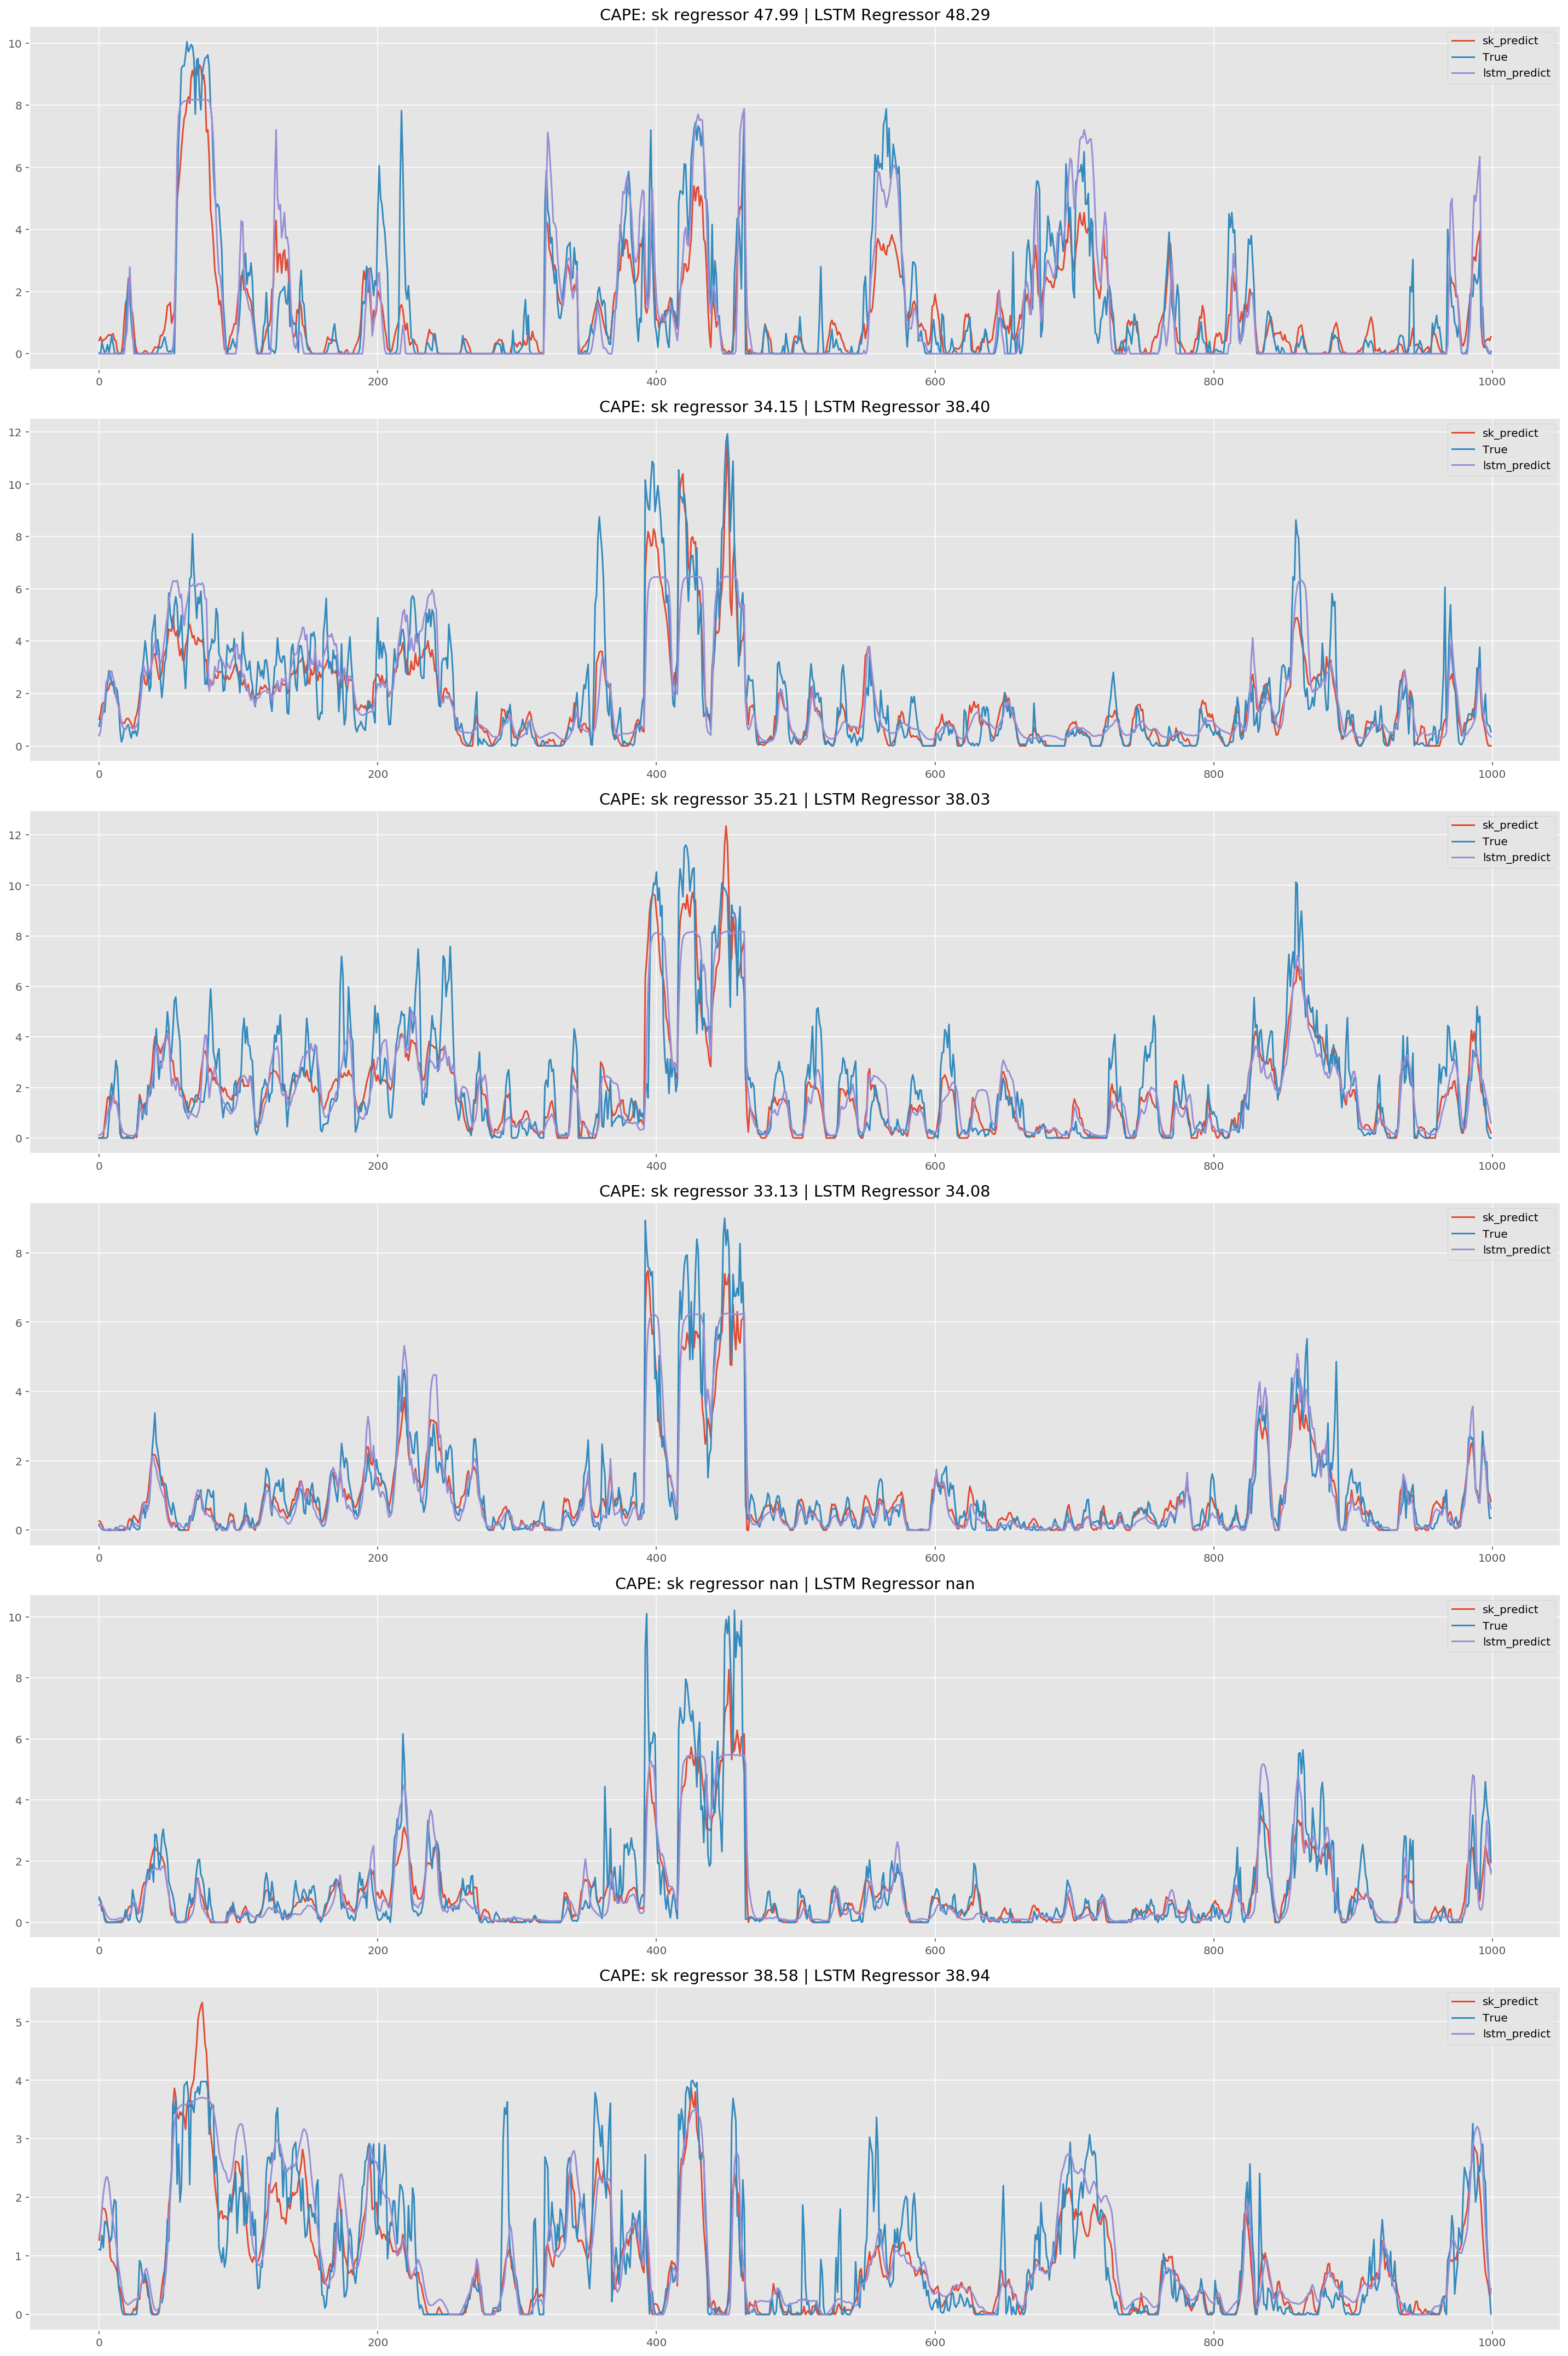

In [55]:
window = slice(1000, 2000)
fig, axes = plt.subplots(6, 1, figsize = (20, 5 * 6))
for i, ax in enumerate(axes):
    ax.plot(sk_predictions[i][window], label='sk_predict')
    ax.plot(prod_wfs[i][window], label='True')
    ax.plot(lstm_predictions[i][window], label='lstm_predict')
    ax.legend()
    ax.set_title(f"CAPE: sk regressor {CAPE_CNR_function(prod_wfs[i], sk_predictions[i]):.2f} | LSTM Regressor {CAPE_CNR_function(prod_wfs[i], lstm_predictions[i]):.2f}")
plt.tight_layout()

fig.savefig('images/train_predictions.png')

plt.show()

### On test

In [68]:
df_test = load_data('data/X_test_v2.csv', path_Y=None, crop_train_period=False)

In [69]:
features_test_lstm = all_features(df_test, get_diff=[], test_set=True)
features_test_sk = all_features(df_test, get_diff=[1, 2, 3], test_set=True)

In [72]:
test_predictions_lstm = lstm_regressor.predict(features_test_lstm)
test_predictions_sk = sk_regressor_full.predict(features_test_sk)

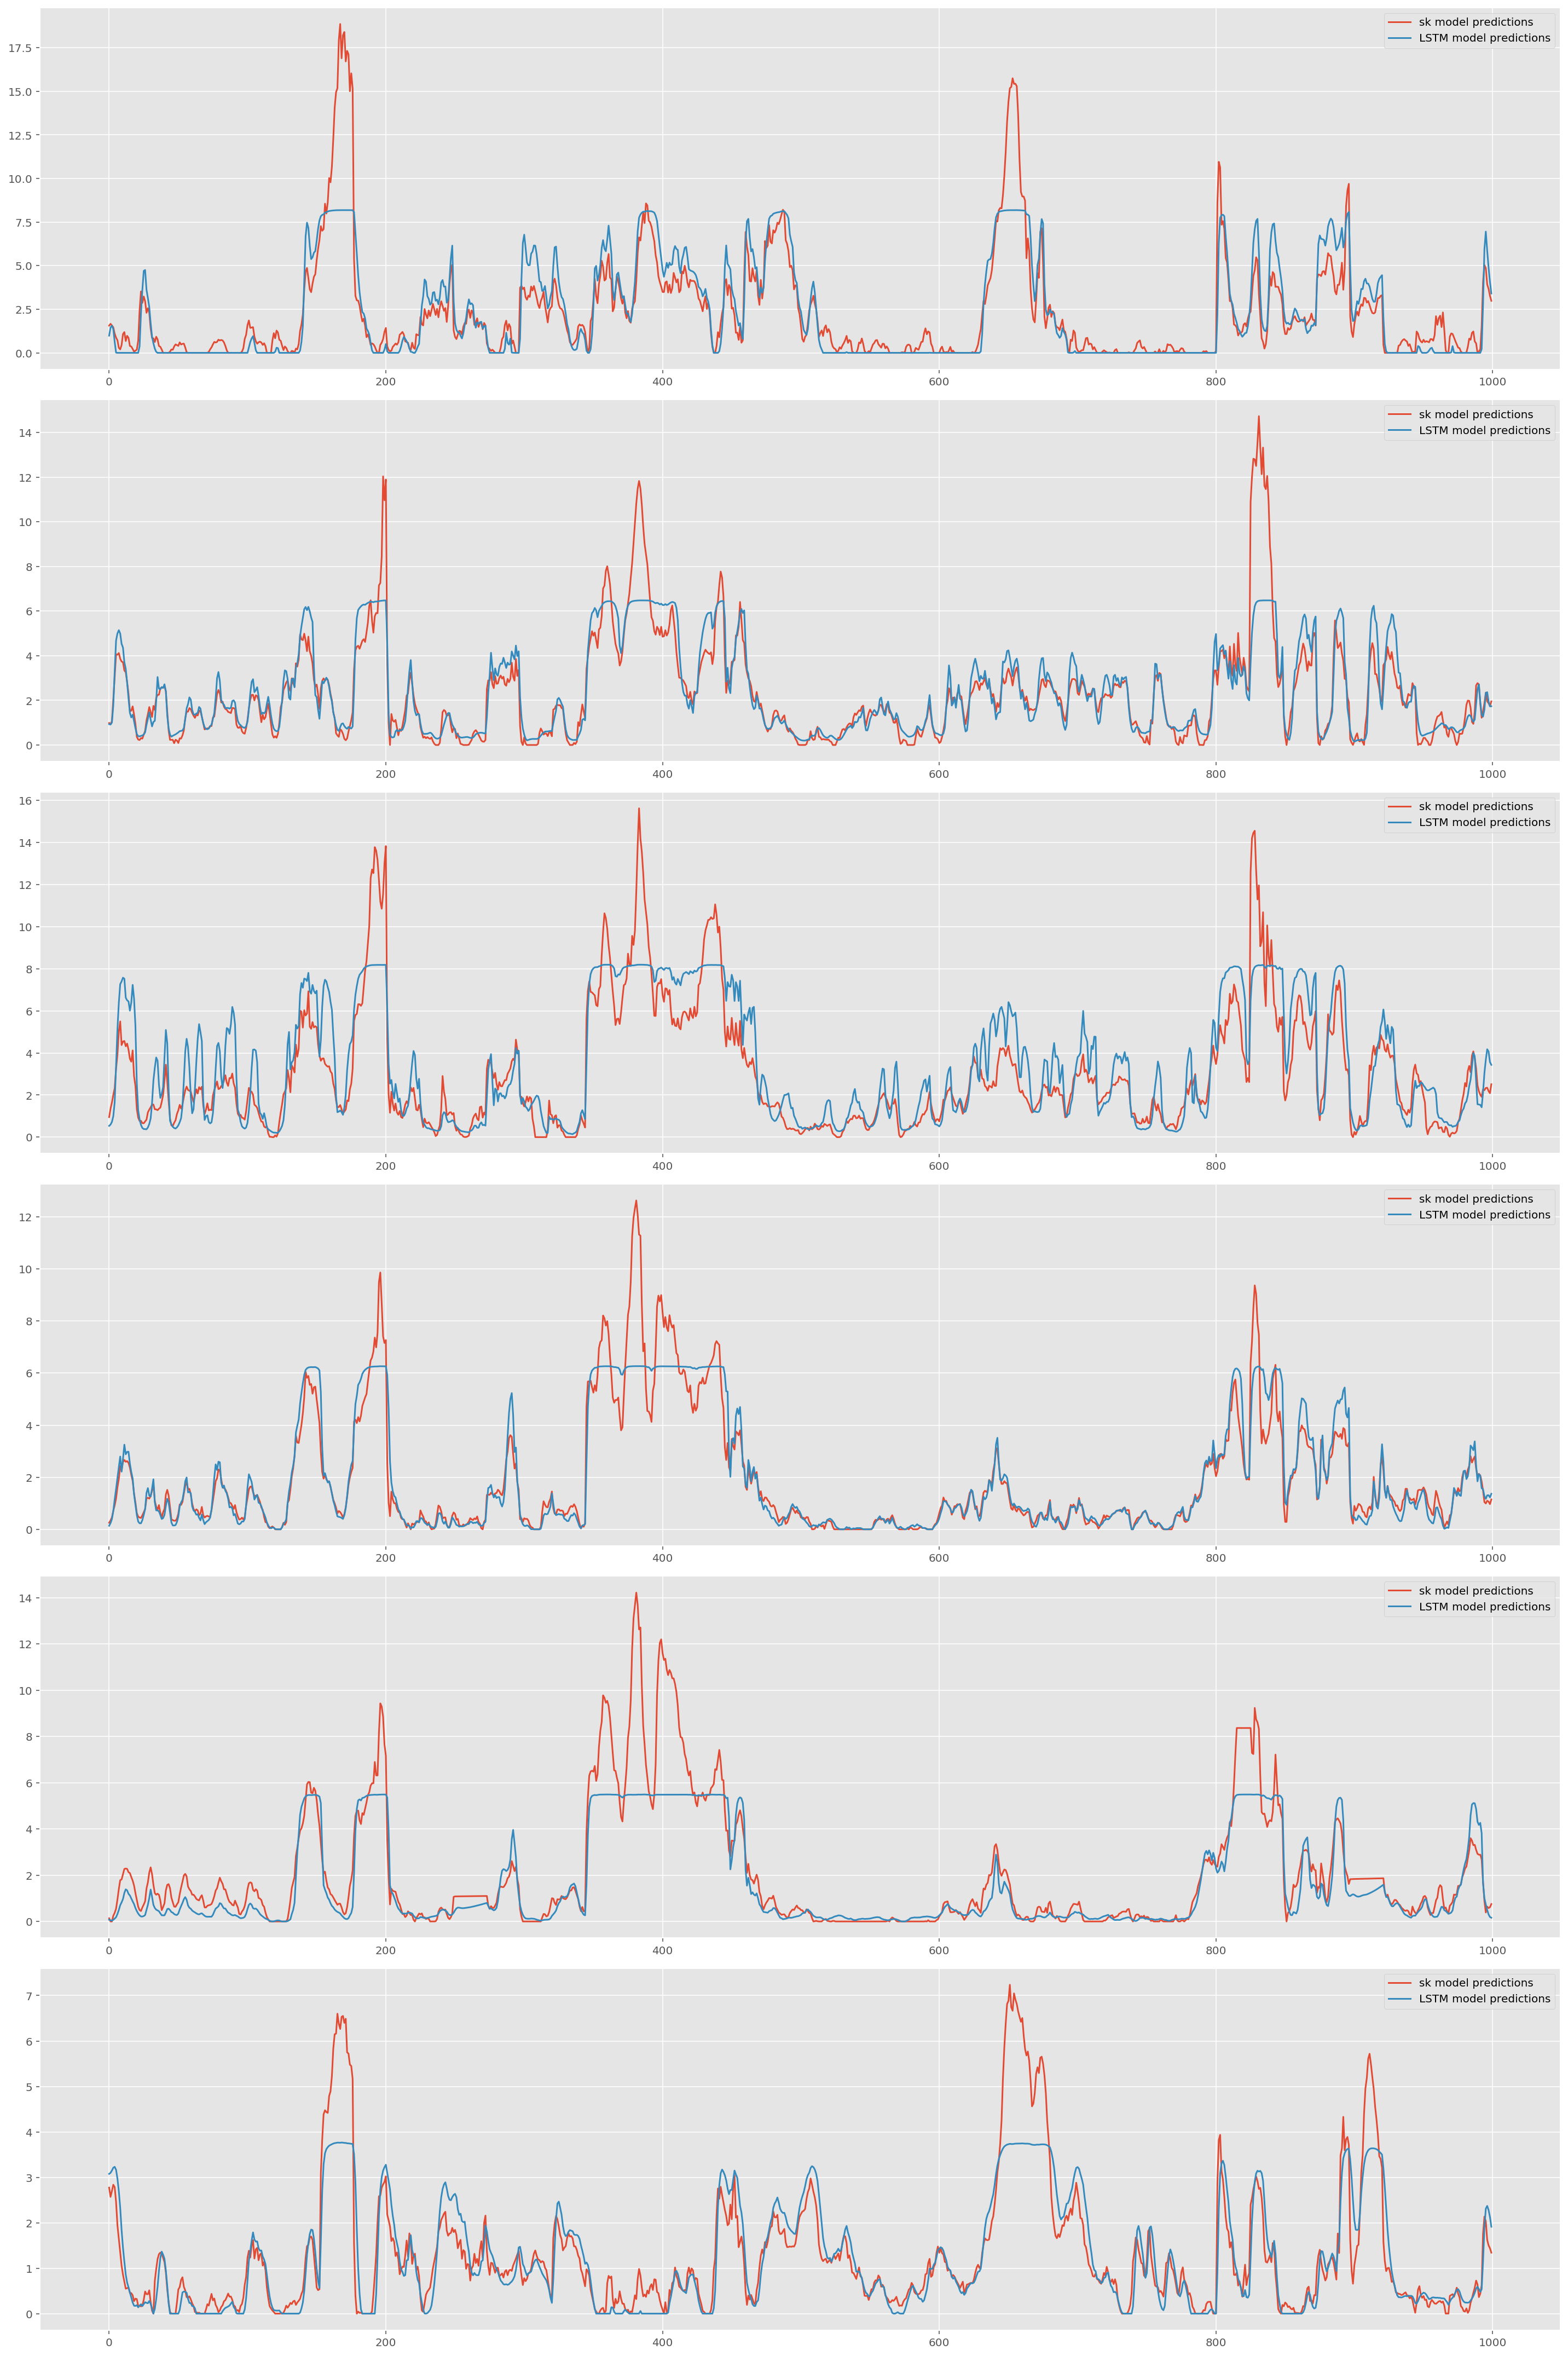

In [75]:
window = slice(1000, 2000)
fig, axes = plt.subplots(6, 1, figsize = (20, 5 * 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.plot(test_predictions_sk[i][window], label='sk model predictions')
    ax.plot(test_predictions_lstm[i][window], label='LSTM model predictions')
    ax.legend()
plt.tight_layout()
fig.savefig('images/test_predictions.png')
plt.show()

In [27]:
aux = features_test_lstm

In [31]:
len(test_predictions_lstm[0])

194

In [66]:
df_test_aux = load_data('data/X_test_v2.csv', path_Y=None, time_index_only=False, crop_train_period=False)

In [34]:
df_test_aux

NWP                          1                                            \
D                           -2                                             
h                           0                        6                     
var                          T       U        V       T       U        V   
Time                WF                                                     
2019-01-02 00:00:00 1   284.67 -6.1127   3.6026  284.22 -5.7656   4.1671   
                    2   281.19  6.1830   4.1271  280.89  5.0313   7.3287   
                    3   277.87  5.5863   8.6094  277.42  2.3807   9.7351   
                    4   276.31  0.4238  11.9710  276.96  2.6860  10.9770   
                    5   276.96  4.3373  10.2190  277.70  4.3097  10.3880   
...                        ...     ...      ...     ...     ...      ...   
2019-01-09 23:00:00 4      NaN     NaN      NaN     NaN     NaN      NaN   
                    5      NaN     NaN      NaN     NaN     NaN      NaN   
                    6      NaN     NaN      NaN     NaN     NaN      NaN   
2019-01-10 00:00:00 5   288.80  4.8417  10.3570  288.55  5.3756   9.3293   
2019-01-10 01:00:00 5   288.93  5.1262   9.9304  288.76  5.7547   9.8094   

NWP                                                      ...         4       \
D                                                        ...        -1        
h                           12                       18  ...        0    12   
var                          T       U        V       T  ...         V CLCT   
Time                WF                                   ...                  
2019-01-02 00:00:00 1   284.43 -8.7461   6.6646  284.19  ...  3.196278  NaN   
                    2   280.89  5.4996   6.6646  280.60  ...  4.513065  NaN   
                    3   277.23  0.6167   9.4585  276.33  ...  3.675658  NaN   
                    4   275.66  5.2676   8.6320  274.78  ...  2.949548  NaN   
                    5   275.28  5.5972   8.0033  275.70  ...  1.797693  NaN   
...                        ...     ...      ...     ...  ...       ...  ...   
2019-01-09 23:00:00 4   287.69  4.9816  -5.2484  287.41  ... -1.013422  NaN   
                    5   289.28  3.1066  -8.4281  289.03  ... -1.166376  NaN   
                    6   291.08 -0.3855  -7.7953  292.35  ... -2.944126  NaN   
2019-01-10 00:00:00 5   288.50  4.5865  10.2950  288.30  ...       NaN  NaN   
2019-01-10 01:00:00 5   288.28  4.8145   9.9350  288.80  ...       NaN  NaN   

NWP                                                       
D                                 0                       
h                                0            12          
var                      U   V CLCT   U   V CLCT   U   V  
Time                WF                                    
2019-01-02 00:00:00 1  NaN NaN  NaN NaN NaN  NaN NaN NaN  
                    2  NaN NaN  NaN NaN NaN  NaN NaN NaN  
                    3  NaN NaN  NaN NaN NaN  NaN NaN NaN  
                    4  NaN NaN  NaN NaN NaN  NaN NaN NaN  
                    5  NaN NaN  NaN NaN NaN  NaN NaN NaN  
...                     ..  ..  ...  ..  ..  ...  ..  ..  
2019-01-09 23:00:00 4  NaN NaN  NaN NaN NaN  NaN NaN NaN  
                    5  NaN NaN  NaN NaN NaN  NaN NaN NaN  
                    6  NaN NaN  NaN NaN NaN  NaN NaN NaN  
2019-01-10 00:00:00 5  NaN NaN  NaN NaN NaN  NaN NaN NaN  
2019-01-10 01:00:00 5  NaN NaN  NaN NaN NaN  NaN NaN NaN  

[1130 rows x 102 columns]

In [76]:
lstm_full_predictions = []
indices = [0] * 6
for i, j in df_test_aux.index:
    lstm_full_predictions.append(test_predictions_lstm[j-1][indices[j-1]])
    indices[j-1] += 1
lstm_full_predictions = np.array(lstm_full_predictions)

In [77]:
brut_test = pd.read_csv('data/X_test_v2.csv')

In [84]:
lstm_full_predictions.size

36529

In [99]:
lstm_full_predictions

array([3.615557  , 2.2734122 , 2.4901795 , ..., 0.4197576 , 5.479857  ,
       0.68062156], dtype=float32)

In [103]:
np.vstack([brut_test['ID'].values, lstm_full_predictions]).T

array([[3.73760000e+04, 3.61555696e+00],
       [3.73770000e+04, 2.27341223e+00],
       [3.73780000e+04, 2.49017954e+00],
       ...,
       [7.39020000e+04, 4.19757605e-01],
       [7.39030000e+04, 5.47985697e+00],
       [7.39040000e+04, 6.80621564e-01]])

In [90]:
a = np.zeros((brut_test['ID'].values.size, 2))
a[:, 0] = brut_test['ID'].values
a[:, 1] = lstm_full_predictions

In [104]:
lstm_full_predictions_df = pd.DataFrame(np.vstack([brut_test['ID'].values, lstm_full_predictions]).T, columns=['ID', 'Production'])

In [108]:
lstm_full_predictions_df['ID'] = lstm_full_predictions_df['ID'].astype('int')

In [112]:
lstm_full_predictions_df.to_csv('test.csv', index=False)

In [65]:
brut_test

,ID,WF,Time,NWP1_00h_D-2_U,NWP1_00h_D-2_V,NWP1_00h_D-2_T,NWP1_06h_D-2_U,NWP1_06h_D-2_V,NWP1_06h_D-2_T,NWP1_12h_D-2_U,...,NWP4_00h_D-1_CLCT,NWP4_12h_D-1_U,NWP4_12h_D-1_V,NWP4_12h_D-1_CLCT,NWP4_00h_D_U,NWP4_00h_D_V,NWP4_00h_D_CLCT,NWP4_12h_D_U,NWP4_12h_D_V,NWP4_12h_D_CLCT
0,37376,WF1,16/01/2019 01:00,-4.5500,-1.5148,279.01,-3.0484,-2.6405,278.01,-3.3630,...,-0.000016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,37377,WF1,16/01/2019 02:00,-5.7942,0.4186,279.38,-3.1155,-0.4923,277.86,-3.6398,...,-0.000016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,37378,WF1,16/01/2019 03:00,-5.9803,1.0079,280.13,-2.9582,1.1965,277.80,-3.6668,...,-0.000016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,37379,WF1,16/01/2019 04:00,-6.1664,0.4983,280.74,-2.5532,2.3753,277.88,-3.8536,...,7.854044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,37380,WF1,16/01/2019 05:00,-6.9187,0.2228,280.95,-2.7366,2.4846,278.47,-4.5220,...,-0.000016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36524,73900,WF6,30/09/2019 18:00,NaN,NaN,NaN,-2.2144,-4.4093,293.82,-3.7198,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36525,73901,WF6,30/09/2019 19:00,NaN,NaN,NaN,NaN,NaN,NaN,-3.7546,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36526,73902,WF6,30/09/2019 20:00,NaN,NaN,NaN,NaN,NaN,NaN,-0.7466,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36527,73903,WF6,30/09/2019 21:00,NaN,NaN,NaN,NaN,NaN,NaN,1.7238,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
